In [7]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../libs')
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic
import stats_lib

np.random.seed(200)

In [8]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData
wa-sa-D3, files: 14                     wa-sa-A3, files: 13                     wa-sa-C3, files: 13
wa-sa-A5, files: 13                     wa-sa-A2, files: 14                     wa-sa-A1, files: 13
wa-sa-A4, files: 13                     wa-sa-D2, files: 13                     wa-sa-B5, files: 13
wa-sa-B1, files: 13                     wa-sa-D4, files: 13                     wa-sa-C2, files: 13
wa-sa-C5, files: 13                     wa-sa-B2, files: 13                     wa-sa-D5, files: 14
wa-sa-B4, files: 13                     wa-sa-B3, files: 13                     wa-sa-C4, files: 13
wa-sa-D1, files: 13                     wa-sa-C1, files: 13   

### Get samples for negative control

In [12]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                    # probelmatic dimension 3
                                     #"wa-sa-B3",  
                                     #"wa-sa-A2", 
                                     #"wa-sa-B2", 
                                    #  "wa-sa-A3",
                                    #  "wa-sa-A1", 
                                    #  "wa-sa-B1", 
                                     
                                    #  "wa-sa-D2",
                                    #  "wa-sa-D1",
                                    #  #"wa-sa-C2",

                                    #  #"wa-sa-B4",
                                    #  #"wa-sa-C4",
                                    #  #"wa-sa-A4",

                                    #  "wa-sa-A5", 
                                     "wa-sa-C3", # Pos
                                    #  "wa-sa-D3", # Zero
                                     #"wa-sa-D4", 
                                     #"wa-sa-C5", # Pos
                                     #"wa-sa-D5", # Zero
                                     #"wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [13]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 1.2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.WhitnesDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.2,
                                     eps=0.4,
                                     outlier_quantile=0.0001,
                                     prediction_axis=prediction_axis,
                                     verbose=True
                                     )
df_decision = decision.predict(np_wa)

Finished compute clusters in 0.32263994216918945 seconds
Finished compute transformed features in 0.03544116020202637 seconds
Finished predict cluster labels in 0.09626126289367676 seconds
Finished predict labels in 0.009814023971557617 seconds


all_data: array([580649.61363481, 567201.03343863, 519810.41037185, 775454.94531809, 629424.8984976 , 626092.23288712])
zero_cluster: array([4552.02708072, 4057.98121764, 3611.95697644, 4519.02878668, 1311.93240028, 3594.29422528]

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 5.277044854881267e-05, n_outlier: 1

Total error rate: 0.0026122771595245937
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.007168     0.005867        0.0        0.0        0.0 0.002639

Precision (TP / (TP + FP)): 1.0
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0          1.0        0.0        0.0        0.0      1.0

Recall / TPR (TP / (TP + FN)): 0.9270169923304155
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.079983        0.0        0.0        0.0      1.0

Specificity / TNR (TN / (TN + FP)): 1.0
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0          1.0        1.0        1.0        1.0      1.0

Accuracy ((TP + TN) / (P + N)): 0.9997354846878009
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.998409        1.0        1.0        1.0      1.0

F1 (2 * (precision * recall) / (precision + recall)

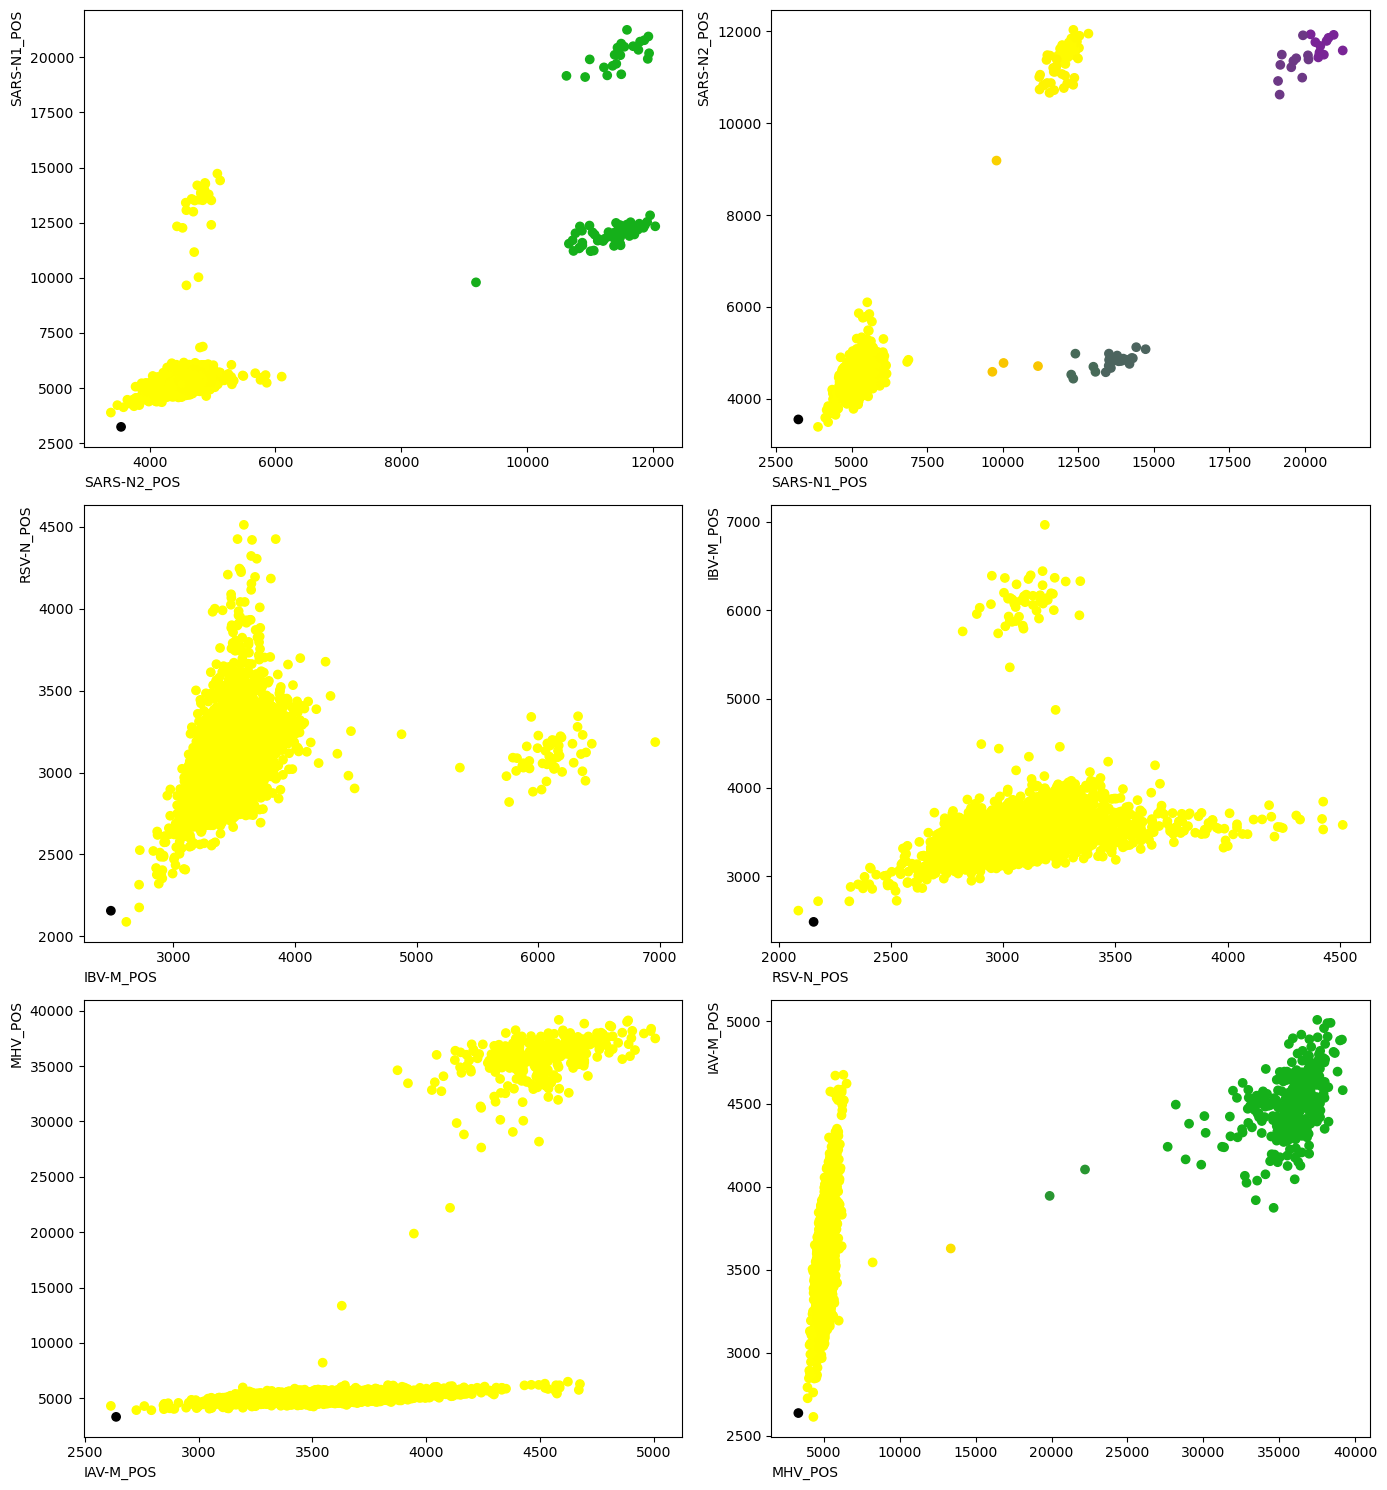

In [14]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.probabilities_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions, threshold=0.5)


plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )